# 4. Comparing data in the signal and wrong-sign containers

In data, our signal $B^0$ candiates are formed by combining a $D^{*-}$ with two positive pions and a negative pion (or a $D^{*+}$ with two negative pions and a positive one). Overall, the electric charge of this combination is zero, as expected for a $B^0$ decay.

Not all of the combinations in data are going to be genuine signal - sometimes you combine pions from some other process in the event, which adds background to your sample. We call this type of background `combinatroial`. We can mimic this type of background in data by creating so-called `wrong-sign` combinations. Here, we take a $D^{*-}$ and combine it with two negative pions and a positive one. The overall charge combination here is clearly non-physical, which means the sample won't include any genuine signal decays. Thus, it gives us an idea of what the background looks like when you randomly add together pions.

As part of this project, we will train a machine learning algorithm to learn the differences between genuine signal decays and combinatorial background. We can use `scikit-learn` to do this, employing `Gradient Boosted Decision Trees` (BDT). We can compare our signal MC sample of $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ with the wrong-sign background in data, giving the BDT a list of variables to compare. The BDT then gives us a classifier decision variable, which we can use to discriminate between signal and background in our real data. 

Some imports of what we need:

In [1]:
from root_pandas import read_root
import matplotlib.pyplot as plt
from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets
import numpy as np

#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.22/02


Let's load the signal candidate data and the wrong-sign data into some DataFrames:

In [26]:
df = {}
file_list_sig = []
for y in years:
    for m in magnets:
        file_list_sig.append(f"{loc.DATA_STRIP}/data_90000000_{y}_{m}.root")
tree_name = "DecayTreeTuple/DecayTree"
vars = ["B0_M","Dst_M","D0_M"]
df["sig"] = read_root(file_list_sig, tree_name, columns=vars)

file_list_ws = []
for y in years:
    for m in magnets:
        file_list_ws.append(f"{loc.DATA_WS_STRIP}/dataWS_90000000_{y}_{m}.root")
tree_name = "DecayTreeTuple/DecayTree"
df["ws"] = read_root(file_list_ws, tree_name, columns=vars)

Let's calculate the $\Delta M = m(D^*) - m(D^0)$ for each sample:

In [27]:
for d in df:
    df[d]["Delta_M"] = df[d]["Dst_M"] - df[d]["D0_M"]

Plotting the $\Delta M$ shows us that quite a lot of the data is from fake $D^*$ combinations:

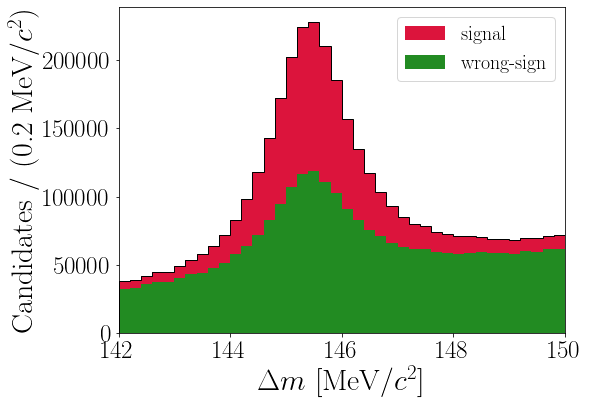

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
low_Delta_M = 142.
high_Delta_M = 150.
bin_width = 0.2
units = "MeV/$c^2$"
n_bins = int((high_Delta_M - low_Delta_M)/bin_width)
plt.hist(df["sig"]["Delta_M"], bins=n_bins, range=(low_Delta_M,high_Delta_M),histtype='step',color='k')
plt.hist(df["sig"]["Delta_M"], bins=n_bins, range=(low_Delta_M,high_Delta_M),histtype='stepfilled',color='crimson',label='signal')
plt.hist(df["ws"]["Delta_M"], bins=n_bins, range=(low_Delta_M,high_Delta_M),histtype='stepfilled',color='forestgreen',label='wrong-sign')
plt.xlim(low_Delta_M,high_Delta_M)
plt.xlabel("$\Delta m$ [%s]" % units,fontsize=30)
plt.ylabel(f"Candidates / ({bin_width:.1f} {units})", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=20)
plt.show()

The wrong-sign data still contains some real $D^*$'s as well, since it is possible to combine a real $D^*$ with some random pions to make a wrong-sign candidate. 

Let's clean up our samples a bit by cutting on $143 < \Delta m < 148$:

In [30]:
for d in df:
    df[d] = df[d].query("Delta_M > 143. and Delta_M < 148.")

Now we plot the $B^0$ candidate masses in the remaining signal and wrong-sign data:

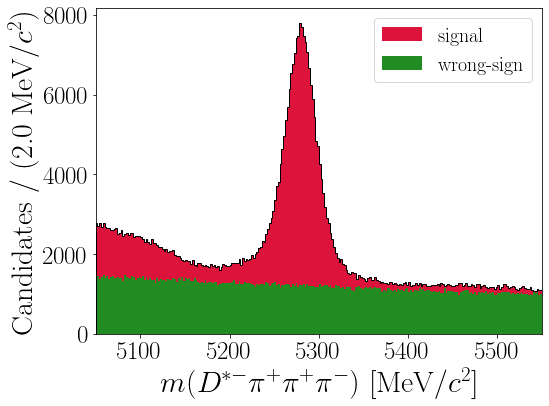

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
low = 5050.
high = 5550.
bin_width = 2.
n_bins = int((high - low)/bin_width)
plt.hist(df["sig"]["B0_M"], bins=n_bins, range=(low,high),histtype='step',color='k')
plt.hist(df["sig"]["B0_M"], bins=n_bins, range=(low,high),histtype='stepfilled',color='crimson',label='signal')
plt.hist(df["ws"]["B0_M"], bins=n_bins, range=(low,high),histtype='stepfilled',color='forestgreen',label='wrong-sign')
plt.xlim(low,high)
plt.xlabel("$m(D^{*-}\pi^+\pi^+\pi^-)$ [MeV/$c^2$]",fontsize=30)
plt.ylabel(f"Candidates / ({bin_width:.1f} {units})", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(fontsize=20)
plt.show()

There are a few things to notice in this plot:
- Only the signal data, where we have the correct charge combination, has a $B^0$ peak.
- The wrong-sign data is similar to the signal data in the upper mass region. This is the region where there shouldn't be any physical combinations. The fact that the distributions don't agree perfectly means that the probability of having a random combination $D^{*-}$ + $\pi^+ \pi^- \pi^-$ isn't quite the same as a random combination $D^{*-}$ + $\pi^+ \pi^+ \pi^-$. But it's clear that the general shape of the background in this region is very similar. 
- There are extra events in the signal data at low mass (below 5150 MeV). These are from decays such as $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- \pi^0$, where a neutral pion produced in the decay is not reconstructed. Why do such decays sit at lower mass values?


**Follow-up tasks**
- Use the wrong-sign data samples and the $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ signal MC to train a BDT. The BDTs job will be to classify events as signal or combinatorial background. You will need to choose some input variables from your tree to train the classifier (see below).
- Apply this BDT to the **signal data**, which has not been used in the training. The result should be a BDT distribution for the signal data, with high values corresponding to a high signal probability and a low value corresponding to a high background probability.
- You can use [scikit-learn](https://scikit-learn.org/stable/) for this sort of task. You'll find a ROOT-based tutorial [here](https://betatim.github.io/posts/sklearn-for-TMVA-users/).
- Prepare a plot of the signal MC and wrong-sign data BDT distributions. How do they compare? Are they well separated?
- Can you make a ROC curve of the BDT performance?
- How does the BDT distribution look in the signal data?
- What happens to the $m(B^0)$ distribution in the signal data when you apply a cut to the BDT?

Some ideas for variables to use in the BDT, to discriminate between signal and wrong-sign background:
 - `B0_P` and `B0_PT` ($B^0$ candidate kinematics)
 - `D0_P` and `D0_PT` ($D^0$ candidate kinematics)
 - `Dst_P` and `Dst_PT` ($D^*$ candidate kinematics)
 - `tau_pion0_P` and `tau_pion0_PT`, and the same for `tau_pion1` and `tau_pion2` (three pions kinematics)
 - `tau_pion0_TRACK_CHI2NDOF`, and the same for `tau_pion1` and `tau_pion2` (three pions track fit quality)
 - `B0_ENDVERTEX_CHI2` ($B^0$ vertex quality)
 - `D0_ENDVERTEX_CHI2` ($D^0$ vertex quality)
 - `tau_ENDVERTEX_CHI2` ($3\pi$ vertex quality)